## Try to maximize the likelihood using iminuit (CMB parameterization)

See tutorials here: https://nbviewer.jupyter.org/github/scikit-hep/iminuit/tree/master/tutorial/

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 140
mpl.rcParams['figure.dpi'] = 140
import numpy as np
# our modules
import camb_cosmo
import CAMB_model
import full_theory
import likelihood
import data_MPGADGET
import gp_emulator
import p1d_arxiv

Setup mock data, from one of simulations in the suite

In [2]:
# specify simulation suite and P1D mesurements
basedir="/p1d_emulator/sim_suites/Australia20/"
skewers_label='Ns500_wM0.05'
p1d_label=None
# specify simulation to use to generate synthetic data
test_sim_num=15
data=data_MPGADGET.P1D_MPGADGET(sim_number=test_sim_num,
                                basedir=basedir,
                                skewers_label=skewers_label,
                                data_cov_factor=1)

Setup archive of P1D measurements from simulations to train the emulator

In [3]:
# specify redshift range
z_max=4
# do not use test_sim_num that was used in generating mock data
arxiv=p1d_arxiv.ArxivP1D(basedir=basedir,drop_sim_number=test_sim_num,
                            drop_tau_rescalings=True,z_max=z_max,
                            drop_temp_rescalings=True,skewers_label=skewers_label)

In [4]:
# specify parameters to be used in emulator
paramList=['mF', 'sigT_Mpc', 'gamma', 'kF_Mpc', 'Delta2_p', 'n_p']
# specify k range
kmax_Mpc=8
# setup GP emulator
emu=gp_emulator.GPEmulator(basedir,p1d_label,skewers_label,z_max=z_max,
                                verbose=False,paramList=paramList,train=False,
                                emu_type="k_bin",passArxiv=arxiv,kmax_Mpc=kmax_Mpc)
emu.load_default()

 /Users/font/Programs/Others/anaconda3/lib/python3.6/site-packages/paramz/parameterized.py:61: RuntimeWarning:Don't forget to initialize by self.initialize_parameter()!


Setup FullTheory, explicit in case we don't use any cosmo param and likelihood gets confused

In [5]:
# specify whether to use true cosmology in simulation as fiducial (easier test)
use_sim_fid=False
if use_sim_fid:
    sim_cosmo=emu.arxiv.get_simulation_cosmology(test_sim_num)
    print('use true cosmo as fiducial')
    camb_cosmo.print_info(sim_cosmo)
    camb_model_sim=CAMB_model.CAMBModel(zs=data.z,cosmo=sim_cosmo)
    theory=full_theory.FullTheory(zs=data.z,emulator=emu,camb_model_fid=camb_model_sim)
else:
    theory=full_theory.FullTheory(zs=data.z,emulator=emu)
    print('use default cosmo as fiducial')
    camb_cosmo.print_info(theory.camb_model_fid.cosmo)

use default cosmo as fiducial
H0 = 6.7000E+01, Omega_b h^2 = 2.2000E-02, Omega_c h^2 = 1.2000E-01, Omega_k = 0.0000E+00, Omega_nu h^2 = 0.0000E+00, A_s = 2.1000E-09, n_s = 9.6500E-01, alpha_s = 0.0000E+00


Setup likelihood and free parameters

In [6]:
# Likelihood parameters (option to fix cosmology)
fix_cosmo=False
if fix_cosmo:
    assert use_sim_fid,'do you want to fix the cosmology when not using the right one?'
    like_params=["ln_tau_0","ln_sigT_kms_0","ln_gamma_0","ln_kF_0"]
    like_param_limits=[[-0.2, 0.2],[-0.2, 0.2], [-0.2, 0.2], [-0.2, 0.2]]
else:
    like_params=["As","ns","ln_tau_0","ln_sigT_kms_0",
            "ln_gamma_0","ln_kF_0"]
    like_param_limits=[[1.0e-9,3.0e-9 ], [0.90, 1.05], [-0.2, 0.2],
            [-0.2, 0.2], [-0.2, 0.2], [-0.2, 0.2]]

In [7]:
like=likelihood.Likelihood(data=data,theory=theory,
                            free_param_names=like_params,
                            free_param_limits=like_param_limits,
                            verbose=False,
                            prior_Gauss_rms=0.5,
                            emu_cov_factor=1)

In [8]:
## Evaluate log_prob at random point in parameter space
theta=np.ones(len(like_params))*0.5 ## Just pick the middle of likelihood space
print('starting point')
for par in like.parameters_from_sampling_point(theta):
    print(par.info_str())
chi2_test=like.get_chi2(theta)
print('starting chi2',chi2_test)

starting point
As = 1.9999999999999997e-09
ns = 0.9750000000000001
ln_tau_0 = 0.0
ln_sigT_kms_0 = 0.0
ln_gamma_0 = 0.0
ln_kF_0 = 0.0
starting chi2 867.1294846478747


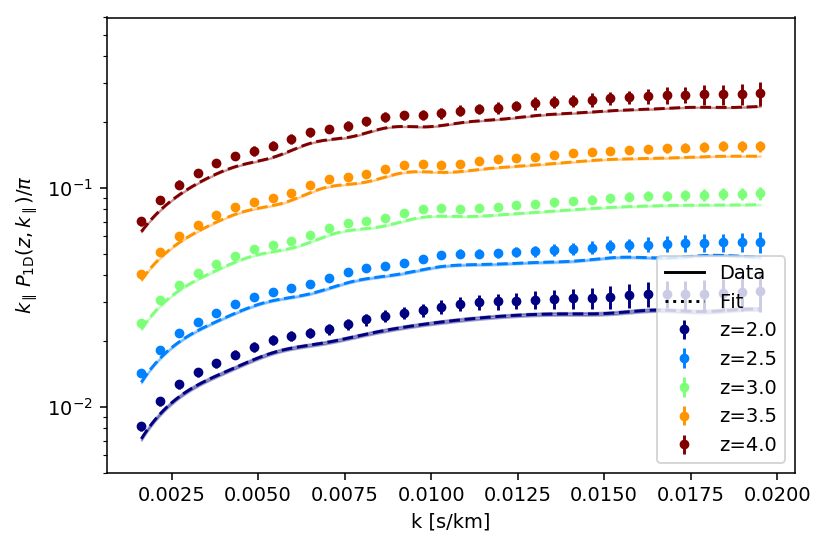

In [9]:
like.plot_p1d(plot_every_iz=2)

# Run iminuit minimiser

In [10]:
from iminuit import Minuit

In [11]:
# setup iminuit
m = Minuit.from_array_func(like.minus_log_prob,theta,error=0.02,errordef=0.5)

In [12]:
# run optimiser
m.migrad()

 /Users/font/Programs/Others/anaconda3/lib/python3.6/site-packages/numpy/linalg/linalg.py:2066: RuntimeWarning:invalid value encountered in slogdet


------------------------------------------------------------------
| FCN = 35.8                    |     Ncalls=397 (397 total)     |
| EDM = 2.58E-05 (Goal: 5E-06)  |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
------------------------------------------------------------------------------------------
|   | Name |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
------------------------------------------------------------------------------------------
| 0 | x0   |   0.34    |   0.03    |            |            |         |         |       |
| 1 | x1   |   0.44    |   0.05    |            |            |         |         |       |
| 2 | x2   |   0.756   |   0.023   |            |            |         |         |       |
| 3 | x3   |   0.28    |   0.33    |            |            |         |         |       |
| 4 | x4   |   0.23    |   0.09    |            |            |         |         |       |
| 5 | x5   |   0.47    |   0.05    |            |            |         |         |       |
------------------------------------------------------------------------------------------

In [13]:
# access results again
print('best fit values =',m.values)
m.get_fmin()

best fit values = <ValueView of Minuit at 7fe6e60661a8>
  x0: 0.33917348964485794
  x1: 0.44345376242024437
  x2: 0.7560953268815389
  x3: 0.2773179407749401
  x4: 0.2341042777491268
  x5: 0.4723362611611756


------------------------------------------------------------------
| FCN = 35.8                    |     Ncalls=397 (397 total)     |
| EDM = 2.58E-05 (Goal: 5E-06)  |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------

In [14]:
min_chi2=like.get_chi2(m.values)
print('minimum chi2',min_chi2)
for par in like.parameters_from_sampling_point(m.values):
    print(par.info_str())

minimum chi2 4.561553583581331
As = 1.6783469792897158e-09
ns = 0.9665180643630367
ln_tau_0 = 0.1024381307526156
ln_sigT_kms_0 = -0.08907282369002396
ln_gamma_0 = -0.10635828890034929
ln_kF_0 = -0.011065495535529768


In [15]:
# compare to truth
sim_cosmo=emu.arxiv.get_simulation_cosmology(test_sim_num)
print('true As =',sim_cosmo.InitPower.As)
print('true ns =',sim_cosmo.InitPower.ns)

true As = 1.765434e-09
true ns = 0.965899


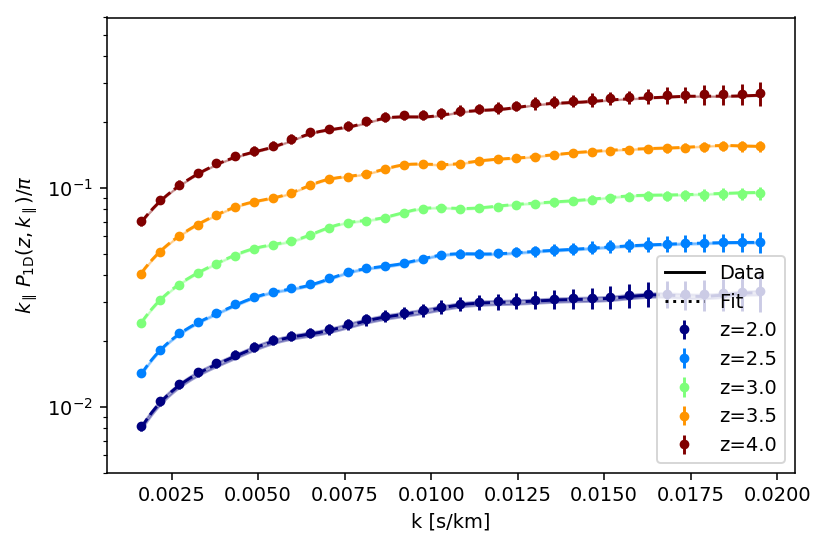

In [16]:
like.plot_p1d(plot_every_iz=2,values=m.values)

# Other cool things we can do with iminuit

In [17]:
# get Gaussian approximated errors
m.hesse()

------------------------------------------------------------------------------------------
|   | Name |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
------------------------------------------------------------------------------------------
| 0 | x0   |   0.34    |   0.03    |            |            |         |         |       |
| 1 | x1   |   0.44    |   0.05    |            |            |         |         |       |
| 2 | x2   |   0.756   |   0.023   |            |            |         |         |       |
| 3 | x3   |   0.28    |   0.33    |            |            |         |         |       |
| 4 | x4   |   0.23    |   0.09    |            |            |         |         |       |
| 5 | x5   |   0.47    |   0.05    |            |            |         |         |       |
------------------------------------------------------------------------------------------

In [18]:
# get proper errors from likelihood scans
m.minos()

 /Users/font/Programs/Others/anaconda3/lib/python3.6/site-packages/numpy/linalg/linalg.py:2066: RuntimeWarning:invalid value encountered in slogdet


-------------------------------------------------
|       x0        |            Valid            |
-------------------------------------------------
|      Error      |    -0.04     |     0.03     |
|      Valid      |     True     |     True     |
|    At Limit     |    False     |    False     |
|     Max FCN     |    False     |    False     |
|     New Min     |    False     |    False     |
-------------------------------------------------
-------------------------------------------------
|       x1        |            Valid            |
-------------------------------------------------
|      Error      |    -0.05     |     0.05     |
|      Valid      |     True     |     True     |
|    At Limit     |    False     |    False     |
|     Max FCN     |    False     |    False     |
|     New Min     |    False     |    False     |
-------------------------------------------------
-------------------------------------------------
|       x2        |            Valid            |
-------------------------------------------------
|      Error      |    -0.024    |     0.023    |
|      Valid      |     True     |     True     |
|    At Limit     |    False     |    False     |
|     Max FCN     |    False     |    False     |
|     New Min     |    False     |    False     |
-------------------------------------------------
-------------------------------------------------
|       x3        |           Invalid           |
-------------------------------------------------
|      Error      |     -0.3     |      0.4     |
|      Valid      |    False     |     True     |
|    At Limit     |    False     |    False     |
|     Max FCN     |    False     |    False     |
|     New Min     |    False     |    False     |
-------------------------------------------------
-------------------------------------------------
|       x4        |            Valid            |
-------------------------------------------------
|      Error      |    -0.07     |     0.11     |
|      Valid      |     True     |     True     |
|    At Limit     |    False     |    False     |
|     Max FCN     |    False     |    False     |
|     New Min     |    False     |    False     |
-------------------------------------------------
-------------------------------------------------
|       x5        |            Valid            |
-------------------------------------------------
|      Error      |    -0.05     |     0.05     |
|      Valid      |     True     |     True     |
|    At Limit     |    False     |    False     |
|     Max FCN     |    False     |    False     |
|     New Min     |    False     |    False     |
-------------------------------------------------

In [19]:
# get best-fit values
m.np_values()

array([0.33917349, 0.44345376, 0.75609533, 0.27731794, 0.23410428,
       0.47233626])

In [20]:
like.get_free_parameter_list()

['As', 'ns', 'ln_tau_0', 'ln_sigT_kms_0', 'ln_gamma_0', 'ln_kF_0']

In [21]:
# get parameters covariance
m.np_covariance()

array([[ 1.18792849e-03, -2.27239744e-04, -6.83059681e-04,
         4.64519940e-03,  1.20298535e-03,  1.01156492e-03],
       [-2.27239744e-04,  2.49672605e-03, -2.21083757e-04,
        -2.54778715e-03,  8.40610289e-06, -1.27606758e-03],
       [-6.83059681e-04, -2.21083757e-04,  5.45633778e-04,
        -3.48863515e-03, -3.28539449e-04, -4.85145728e-04],
       [ 4.64519940e-03, -2.54778715e-03, -3.48863515e-03,
         1.07720540e-01,  1.12789755e-02,  6.60040502e-03],
       [ 1.20298535e-03,  8.40610289e-06, -3.28539449e-04,
         1.12789755e-02,  7.28630243e-03,  1.42651564e-03],
       [ 1.01156492e-03, -1.27606758e-03, -4.85145728e-04,
         6.60040502e-03,  1.42651564e-03,  2.27350924e-03]])

(array([0.34351926, 0.36572693, 0.3879346 , 0.41014226, 0.43234993,
        0.4545576 , 0.47676526, 0.49897293, 0.5211806 , 0.54338826]),
 array([37.7516218 , 36.99803324, 36.41975474, 36.02591954, 35.82590969,
        35.82414247, 36.01384911, 36.37378036, 36.86737323, 37.44486279]))

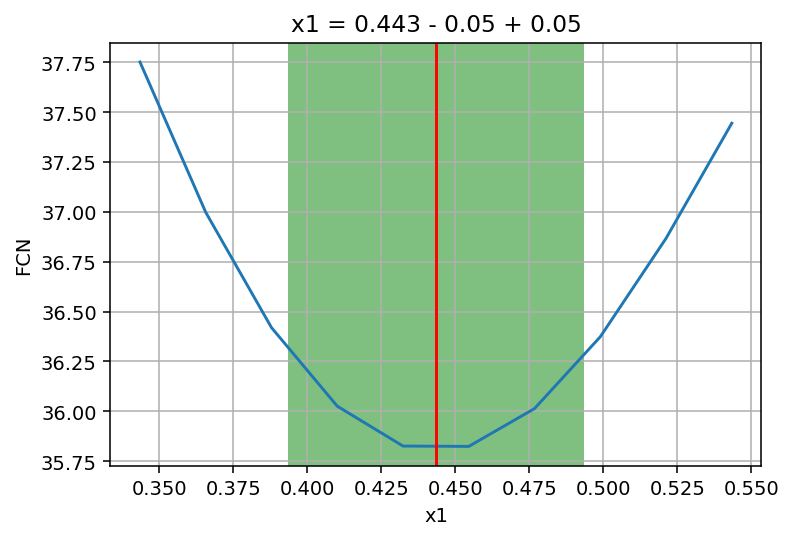

In [22]:
# scan one parameter and plot minus log posterior
m.draw_mnprofile(vname='x1',bins=10)

 /Users/font/Programs/Others/anaconda3/lib/python3.6/site-packages/numpy/linalg/linalg.py:2066: RuntimeWarning:invalid value encountered in slogdet


(array([-0.37909821, -0.23322795, -0.0873577 ,  0.05851256,  0.20438281,
         0.35025307,  0.49612332,  0.64199358,  0.78786383,  0.93373409]),
 array([        inf,         inf,         inf, 36.07431259, 35.82636809,
        35.82386202, 35.99576813, 36.32204803, 36.80925485, 37.46655447]))

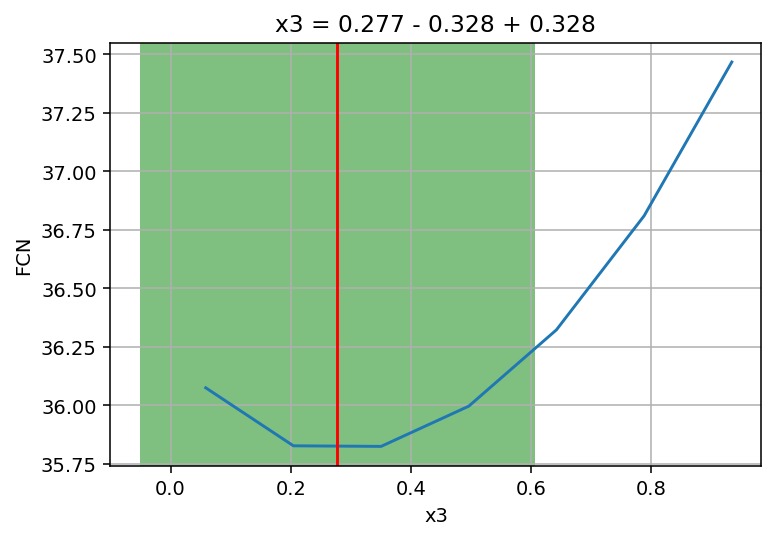

In [23]:
# for another parameter
m.draw_mnprofile(vname='x3',bins=10)

(array([0.27024081, 0.27749688, 0.28475296, 0.29200903, 0.2992651 ,
        0.30652117, 0.31377724, 0.32103331, 0.32828938, 0.33554545,
        0.34280153, 0.3500576 , 0.35731367, 0.36456974, 0.37182581,
        0.37908188, 0.38633795, 0.39359402, 0.4008501 , 0.40810617]),
 array([0.34351926, 0.35403868, 0.3645581 , 0.37507753, 0.38559695,
        0.39611637, 0.40663579, 0.41715521, 0.42767463, 0.43819405,
        0.44871347, 0.45923289, 0.46975231, 0.48027174, 0.49079116,
        0.50131058, 0.51183   , 0.52234942, 0.53286884, 0.54338826]),
 array([[19.88032283, 19.56549734, 19.2209523 , 18.85198866, 18.46505187,
         18.06766448, 17.66824623, 17.27560452, 16.89786389, 16.5406872 ,
         16.20493253, 15.88448134, 15.56576105, 15.23085904, 14.86496894,
         14.46578631, 14.04948234, 13.64880036, 13.30406469, 13.05252347],
        [17.98802496, 17.60254677, 17.18755924, 16.7482646 , 16.29105099,
         15.82342404, 15.35381255, 14.89104007, 14.44326266, 14.01629975,
       

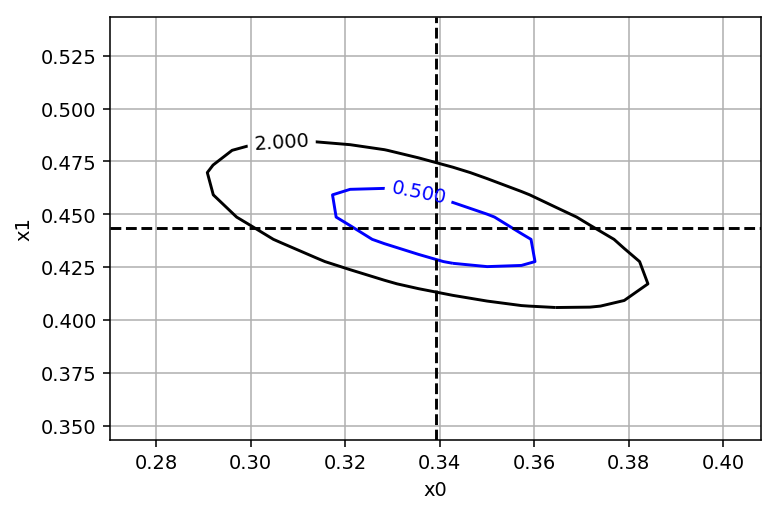

In [24]:
# 2D contours
m.draw_contour('x0','x1',bins=20)

In [25]:
# matrix correlations
m.matrix(correlation=True)

--------------------------------------------------
|    |     x0     x1     x2     x3     x4     x5 |
--------------------------------------------------
| x0 |  1.000 -0.132 -0.848  0.411  0.409  0.616 |
| x1 | -0.132  1.000 -0.189 -0.155  0.002 -0.536 |
| x2 | -0.848 -0.189  1.000 -0.455 -0.165 -0.436 |
| x3 |  0.411 -0.155 -0.455  1.000  0.403  0.422 |
| x4 |  0.409  0.002 -0.165  0.403  1.000  0.350 |
| x5 |  0.616 -0.536 -0.436  0.422  0.350  1.000 |
--------------------------------------------------